# Imports/Functions

In [ ]:
from triples_sampling_utils import *

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fileinput
import os
import shutil
import math
import random as random
from scipy.stats import loguniform
import scienceplots
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import newton

random.seed(1)  # set random seed for consistent sampling
pd.set_option('display.max_columns', None)

os.environ["PATH"] = "/Library/TeX/texbin:" + os.environ["PATH"]

fig_PATH = "~/Desktop/Research/Figures/"
data_PATH = "~/Desktop/Caltech/Data/"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use(["science","notebook"])
plt.rc('font', family='serif')

plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)  # Set x-axis tick label size
plt.rc('ytick', labelsize=20)  # Set y-axis tick label size


# read in Kroupa initial masses

In [3]:
singles_cosmic = pd.read_csv(data_PATH + "cosmic_pop_generalkroupa_singles_lastrow.csv")
singles_cosmic_i = pd.read_csv(data_PATH + "cosmic_pop_generalkroupa_singles_firstrow.csv")
m1s_constantSFR  = singles_cosmic.query("kstar_1<=1 and mass_1>=0.1")['mass_1']
m1s_constantSFR_i = singles_cosmic_i.query("kstar_1<=1 and mass_1>=0.1")['mass_1']

## From single Kroupa IMF, get triple mass
- assumes simple mass ratios

### initial (`_i`)

In [4]:
print(f"N total  Initial= {len(m1s_constantSFR_i)}")

# STEP 1: Assign binaries based on binary fraction of original m1s
binary_mask = np.random.rand(len(m1s_constantSFR_i)) < np.vectorize(get_binary_fraction)(m1s_constantSFR_i)
m1s_binaries_i = m1s_constantSFR_i[binary_mask]
print(f"N binaries Initial = {len(m1s_binaries_i)}")

# STEP 2: Draw secondary stars
q = np.random.uniform(0.1, 1.0, size=len(m1s_binaries_i))
m2s_binaries_i = q * m1s_binaries_i
m12s = m1s_binaries_i + m2s_binaries_i  # Inner binary total mass

# STEP 3: Draw potential tertiaries for all binaries
q3 = np.random.uniform(0.1, 1.0, size=len(m12s))
m3s = q3 * m12s

# STEP 4: Determine most massive component in the triple
m_primary = np.maximum(m3s, m1s_binaries_i)

# STEP 5: Determine which binaries become triples using the primary mass
triple_mask = np.random.rand(len(m1s_binaries_i)) < np.vectorize(get_triple_fraction)(m1s_binaries_i)

# Keep only those that became triples
m1s_triples_i = m1s_binaries_i[triple_mask]
m2s_triples_i = m2s_binaries_i[triple_mask]
m3s_triples_i = m3s[triple_mask]
print(f"N triples Initial = {len(m1s_triples_i)}")


N total  Initial= 371001
N binaries Initial = 26881
N triples Initial = 5763


### final (after 10 Gyr constant SFR)

In [5]:
print(f"N total = {len(m1s_constantSFR)}")

# STEP 1: Assign binaries based on binary fraction of original m1s
binary_mask = np.random.rand(len(m1s_constantSFR)) < np.vectorize(get_binary_fraction)(m1s_constantSFR)
m1s_binaries = m1s_constantSFR[binary_mask]
print(f"N binaries = {len(m1s_binaries)}")

# STEP 2: Draw secondary stars
q = np.random.uniform(0.1, 1.0, size=len(m1s_binaries))
m2s_binaries = q * m1s_binaries
m12s = m1s_binaries + m2s_binaries  # Inner binary total mass

# STEP 3: Draw potential tertiaries for all binaries
q3 = np.random.uniform(0.1, 1.0, size=len(m12s))
m3s = q3 * m12s

# STEP 4: Determine most massive component in the triple
m_primary = np.maximum(m3s, m12s)

# STEP 5: Determine which binaries become triples using the primary mass
triple_mask = np.random.rand(len(m1s_binaries)) < np.vectorize(get_triple_fraction)(m1s_binaries)

# Keep only those that became triples
m1s_triples = m1s_binaries[triple_mask]
m2s_triples = m2s_binaries[triple_mask]
m3s_triples = m3s[triple_mask]
print(f"N triples = {len(m1s_triples)}")


N total = 342458
N binaries = 15046
N triples = 1310


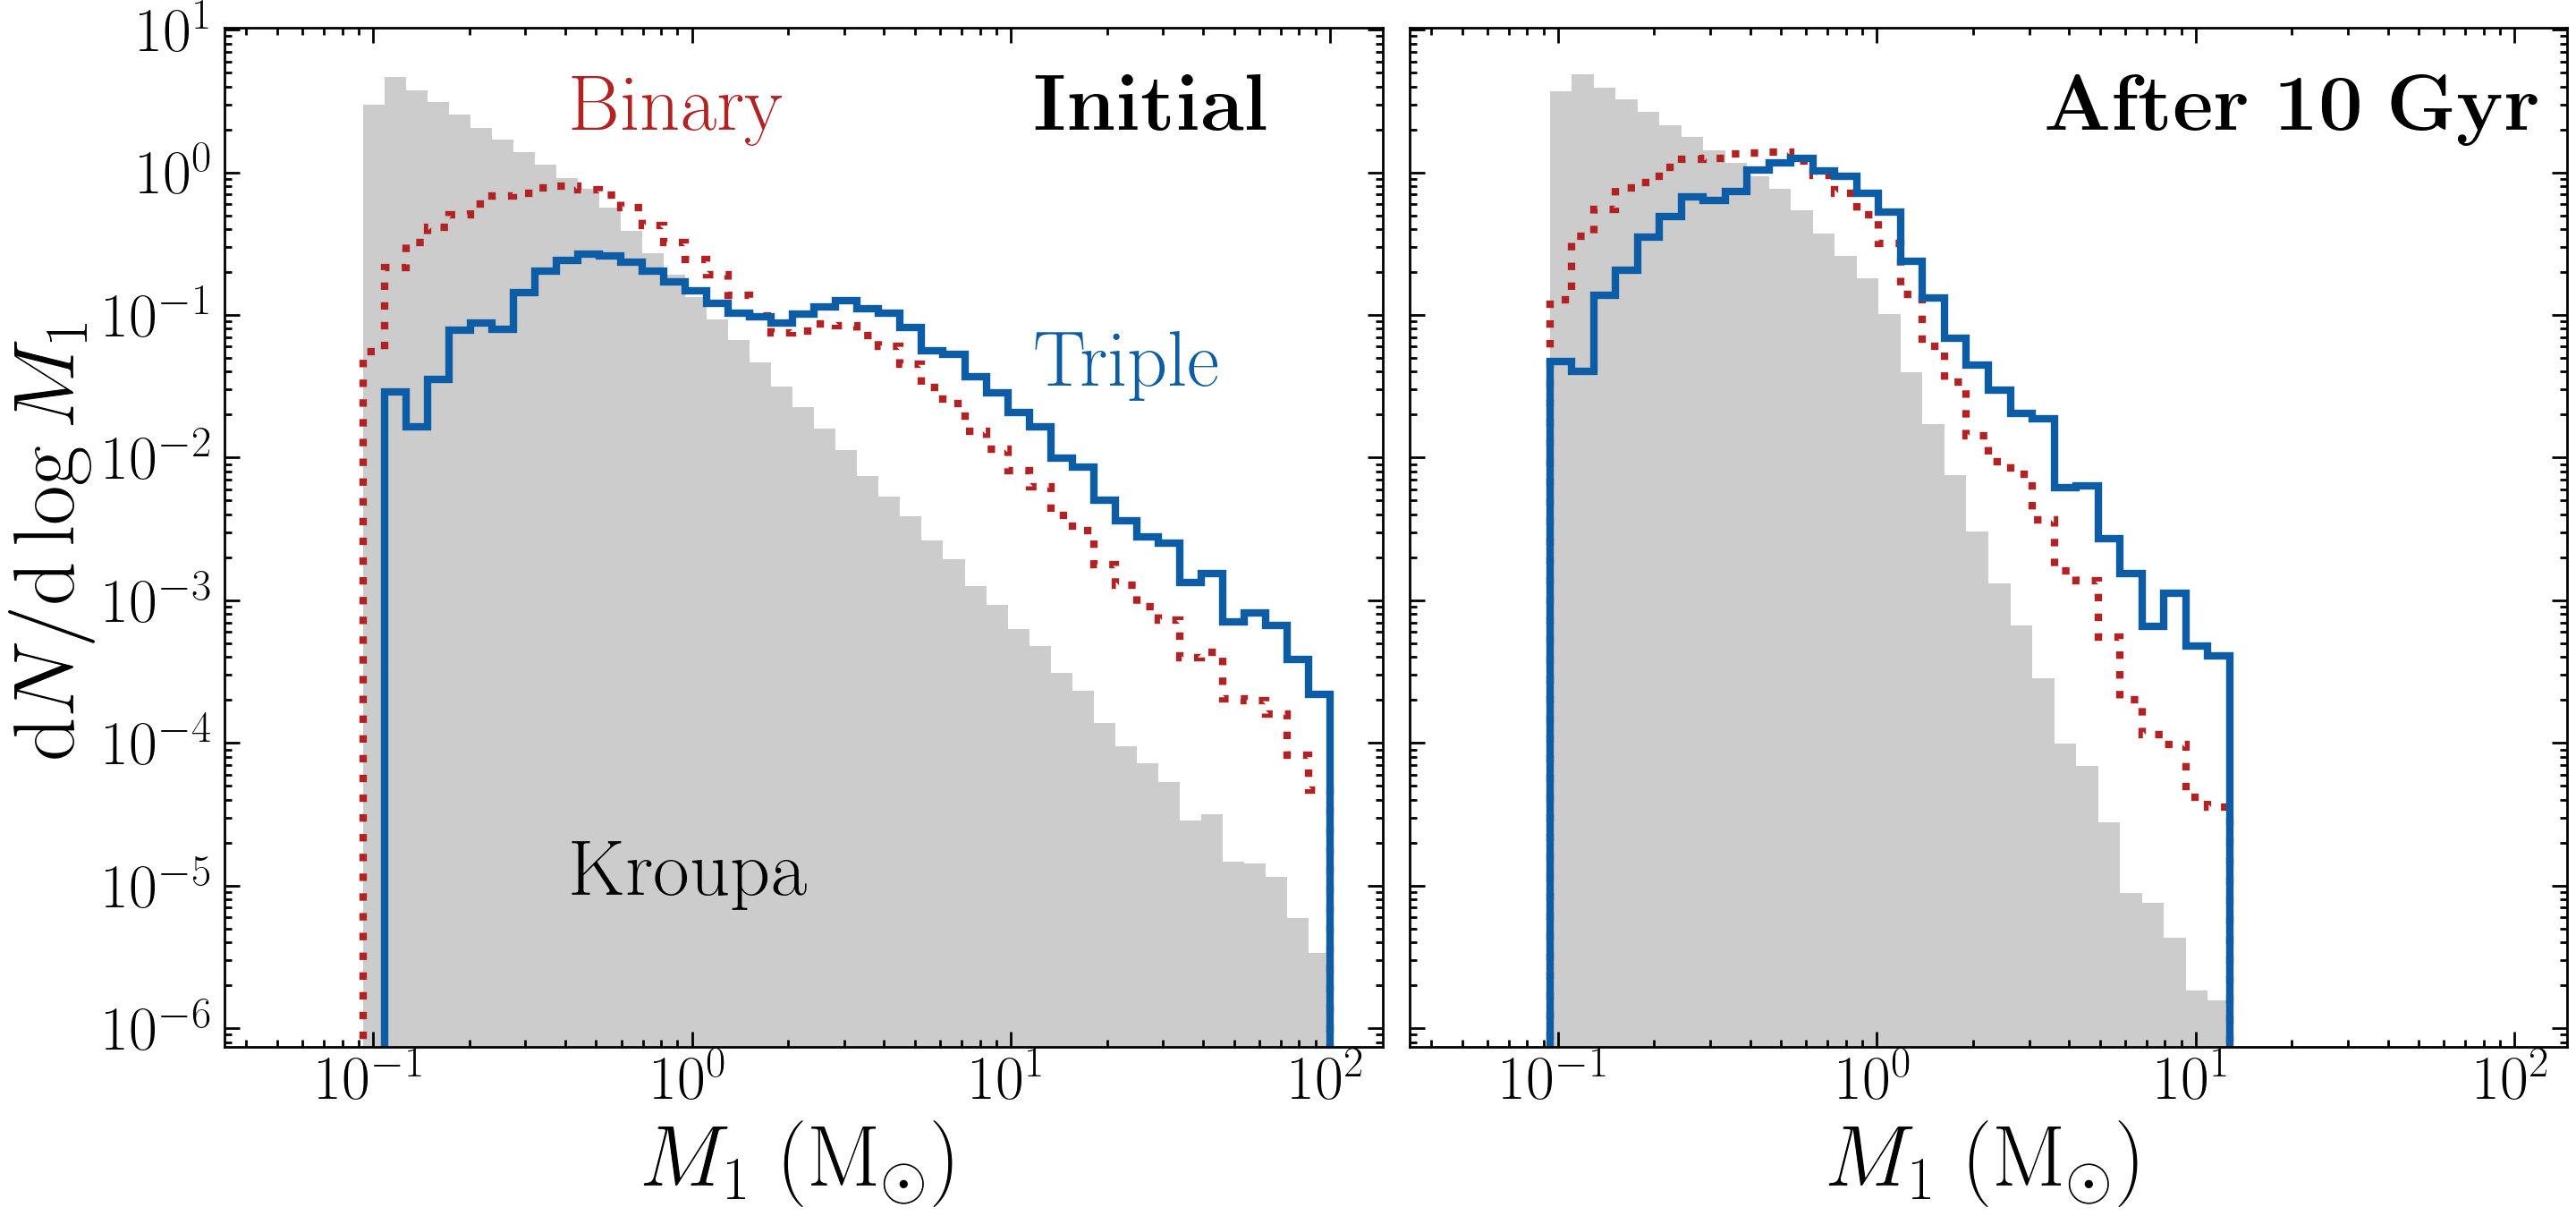

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7),sharey=True)

# First plot
bins = np.logspace(np.log10(0.05), np.log10(100.), 50)
axes[0].hist(m1s_constantSFR_i, bins=bins, density=True, histtype='stepfilled', color='k', linewidth=3, label='', alpha=0.2)
axes[0].hist(m1s_binaries_i, bins=bins, density=True, histtype='step', color='firebrick', linewidth=3, label='Binary', linestyle=':')
axes[0].hist(m1s_triples_i, bins=bins, density=True, histtype='step', color='C0', linewidth=3, label='Triple')

axes[0].set_xlabel(r"$M_1~{\rm (M_\odot)}$", fontsize=35)
axes[0].set_ylabel(r"${\rm d}N/{\rm d}\log M_1$", fontsize=35)
axes[0].text(0.3, 0.15, "Kroupa", transform=axes[0].transAxes, fontsize=32, color='k')
axes[0].text(0.3, 0.9, "Binary", transform=axes[0].transAxes, fontsize=32, color='firebrick')
axes[0].text(0.7, 0.65, "Triple", transform=axes[0].transAxes, fontsize=32, color='C0')
axes[0].text(0.7, 0.9, r"${\bf Initial}$", transform=axes[0].transAxes, fontsize=32, color='k')
axes[0].tick_params(axis='both', labelsize=25)
axes[0].loglog()

# Second plot
bins = np.logspace(np.log10(0.05), np.log10(100.), 49)
axes[1].hist(m1s_constantSFR, bins=bins, density=True, histtype='stepfilled', color='k', linewidth=3, label='', alpha=0.2)
axes[1].hist(m1s_binaries, bins=bins, density=True, histtype='step', color='firebrick', linewidth=3, label='Binary', linestyle=':')
axes[1].hist(m1s_triples, bins=bins, density=True, histtype='step', color='C0', linewidth=3, label='Triple')

axes[1].set_xlabel(r"$M_1~{\rm (M_\odot)}$", fontsize=35)
# axes[1].set_ylabel(r"${\rm d}N/{\rm d}\log M_1$", fontsize=35)
# axes[1].text(0.3, 0.15, "Kroupa", transform=axes[1].transAxes, fontsize=32, color='k')
# axes[1].text(0.3, 0.9, "Binary", transform=axes[1].transAxes, fontsize=32, color='firebrick')
# axes[1].text(0.6, 0.65, "Triple", transform=axes[1].transAxes, fontsize=32, color='C0')
axes[1].text(0.55, 0.9, r"${\bf After~10~Gyr}$", transform=axes[1].transAxes, fontsize=32, color='k')
axes[1].tick_params(axis='both', labelsize=25)
axes[1].loglog()

plt.tight_layout()
plt.show()


# Main Function

In [9]:
def initial_conditions(IMF : str = 'constant_SFR', 
                       Periods : str = 'DM91', 
                       mass_ratios : str = 'default'
                       ): 
    """Sample triple parameters

    Args:
        IMF (str, optional): Initial mass Function for the primary (M1). 
        Periods (str, optional): initial Period Distribution. 
        mass_ratios (str, optional): Mass Ratio Distribution for q_in and q_out.

    Returns:
        _type_: _description_
    """
    
    if IMF == 'Kroupa': 
        m1 = np.random.choice(m1s_triples_i[m1s_triples_i < 2.2]) #random.choices(bins_Kroupa1[:-1], cum_weights = n_Kroupa1)[0]
    elif IMF == 'constant_SFR':
        m1= np.random.choice(m1s_triples)

    if mass_ratios == 'default':
        m2 = m3 = 0
        while m2<0.08 or m3<0.08:
            if m1<0.6:
                q_in  = uniform_twin() 

            elif 0.6 <= m1 <1.2:
                popt = (6.02879393,  1.44315185, -1.44329062, 10.,          0.37202403,  0.79529684) 
                q_in = sample_from_doublebroken(1, *popt)[0]
            elif m1>=1.2:
                popt = (3.60050256,  0.47014287, -2.00243637,  2.1597268,   0.275,       0.59633279) 
                q_in = sample_from_doublebroken(1, *popt)[0]
            m2 =  m1*q_in

            q_out = return_samples(N = 1, which = 2)[0]# np.random.uniform(0.01,1,1)[0] 
            m3 = q_out * (m1+m2) # np.random.choice(m1s_constantSFR) 
    
    
    R1 = 1.01 * m1**(0.8) 
    R2 = 1.01 * m2**(0.8)
    
    beta = np.random.uniform(0,180)
    beta2 = np.random.uniform(0,180)
    
    gamma = 45.
    gamma2 = 45.
    
    g1 = np.random.uniform(0,360)
    g2 = np.random.uniform(0,360)
    
    age = np.random.uniform(0,10e3) #5e3 #*1.e6, 

    if Periods == 'DM91':
        mu,sigma = 4.8, 2.3 
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days #10**np.random.normal(4.8,2.3)
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr
    if Periods == 'Raghavan+10':
        mu,sigma = 5.03, 2.28 
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days 
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr

    if Periods == 'Fischer92': # see also Duchene and Kraus 2013, El-Badry used this in magnetic braking saturates
        mu,sigma = 3.75, 1.3 
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days #10**np.random.normal(4.8,2.3)
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr

    if Periods == 'combined_log_normal':
        if m1 < 0.5:
            mu,sigma = 4.1, 1.3 # if low mass primary, use Fischer (more close binaries)
        else:
             mu,sigma = 4.8, 2.3 # if at elsat K-dward priary, use DM91
        P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days #10**np.random.normal(4.8,2.3)
        P_in,P_out = P_in/365.25, P_out/365.25#P_in/365.25, 1876 #periods in yr
    if Periods == 'Sana+12_days':
        sample1, sample2 = 10**return_samples(N = 1, which = 3)[0]/365.25, 10**return_samples(N = 1, which = 3)[0]/365.25  
        P_in,P_out = np.minimum(sample1, sample2), np.maximum(sample1, sample2)
    if Periods == 'log_uniform':
        periods = sample_log_uniform(x1 = 100, x2=1e7, size=2) #log-uniform in this range in DAYS
        P_in, P_out = np.min(periods)/365.25, np.max(periods)/365.25 #days to year
        
    if Periods == 'eb18':
        alpha = -1.6
        xmin = 50
        xmax = 50000
        seps_sampled = sample_power_law(alpha, xmin, xmax, size=(1, 2))
        a1 = np.min(seps_sampled, axis=1)[0]
        a2 = np.max(seps_sampled, axis=1)[0]
    elif Periods == 'LU':
        seps_sampled = sample_log_uniform(x1 = 10, x2=100000, size=2)
        a1 = np.min(seps_sampled)
        a2 = np.max(seps_sampled)
    
    else:
        a1,a2 = Kepler_3rdLaw(P_in,m1,m2), Kepler_3rdLaw(P_out,m1+m2,m3) 

    ecc = 'uniform'
    sigma_e = 0.3
    
    if ecc == 'thermal':
        e1  = sample_thermal_eccentricity(n_samples = 1)[0]
        e2  = sample_thermal_eccentricity(n_samples = 1)[0]
    elif ecc == 'uniform':
        e1  = np.random.uniform(0,1)
        e2  = np.random.uniform(0,1)
    elif ecc =='Rayleigh':
        e1 = np.random.rayleigh(scale=sigma_e)
        e2 = np.random.uniform(0,1)

    #inclination
    cosi = np.random.uniform(np.cos(0),np.cos(np.pi))
    i = np.rad2deg(np.arccos(cosi))

    t_i = 0.0
    # check if stable
    criteria = get_all_criteria(a1,a2,e1,e2,m1=m1,m2=m2,m3=m3,R1=R1,R2=R2,i=i,q_out=q_out)
    
    if criteria:
        return np.array([m1,m2,m3,R1,R2,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,t_i,age])
    else:
        return initial_conditions(IMF = IMF, Periods = Periods, mass_ratios = mass_ratios)
        

# Sampling Triple Parameters

In [10]:
m1s,m2s,m3s,a1s,a2s,e1s,e2s = [],[],[],[],[], [], []

for _ in range(10000):
    m1,m2,m3,R1,R2,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,t_i,age = initial_conditions(IMF = 'constant_SFR', Periods = 'DM91', mass_ratios='uniform')
    m1s.append(m1),m2s.append(m2),m3s.append(m3)
    a1s.append(a1),a2s.append(a2)
    e1s.append(e1),e2s.append(e2)

m1s,m2s,m3s,a1s,a2s,e1s,e2s =  np.array(m1s).astype(float), np.array(m2s).astype(float), np.array(m3s).astype(float), np.array(a1s).astype(float), np.array(a2s).astype(float), np.array(e1s).astype(float), np.array(e2s).astype(float)

s1s, s2s = compute_projected_separations(a1 = a1s, a2 = a2s, e1 = e1s, e2 = e2s, num_samples = 1)


In [12]:
# Create the DataFrame; each row is a triple with given parameters
results_df = pd.DataFrame({
    'ID': list(range(len(m1s))),
    'm1': m1s,
    'm2': m2s,
    'm3': m3s,
    'sep1_AU': s1s,
    'sep2_AU': s2s,
    'e1': e1s,
    'e2': e2s,
})

results_df = add_resolved_new(results_df, num_iterations=1)

## Apply Gaia selection function
1. Convert Masses to absolute magnitudes (Mg)
2. Sample distances from observed triples to convert Mg to G (apparent magntiude)
3. Apply Contrast ratio limit (angular separation)

In [2182]:
fig_PATH = "~/Desktop/Research/Figures/"
data_PATH = "~/Desktop/Caltech/Data/"

resolved_triples = pd.read_csv(data_PATH + "resolved_triples_500pc.csv")
triples_catalog = pd.read_csv(data_PATH + "triples_catalog.csv")

triple150 = resolved_triples.query("1000/inner_star1_parallax<100 and triple_type == 'MSMS-MS'")


# Separation Distributions

In [2230]:
def sample_all(this_IMF = 'cosmic_constant_SFR', this_Periods = 'DM91', this_IMRD='default'):
    m1s,m2s,m3s,a1s,a2s,e1s,e2s = [],[],[],[],[], [], []

    for _ in range(10000):
        m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,t_i,age,idum = initial_conditions(IMF = this_IMF, Periods = this_Periods, IMRD=this_IMRD)
        m1s.append(m1),m2s.append(m2),m3s.append(m3)
        a1s.append(a1),a2s.append(a2)
        e1s.append(e1),e2s.append(e2)

    m1s,m2s,m3s,a1s,a2s,e1s,e2s =  np.array(m1s).astype(float), np.array(m2s).astype(float), np.array(m3s).astype(float), np.array(a1s).astype(float), np.array(a2s).astype(float), np.array(e1s).astype(float), np.array(e2s).astype(float)

    s1s, s2s = compute_projected_separations(a1 = a1s, a2 = a2s, e1 = e1s, e2 = e2s, num_samples = 1)

    # Create the DataFrame
    results_df = pd.DataFrame({
        'ID': list(range(len(m1s))),
        'm1': m1s,
        'm2': m2s,
        'm3': m3s,
        'a1': s1s,
        'a2': s2s,
        's1': s1s,
        's2': s2s,
        'e2': e2s,
    })

    results_df['sep1_AU'] = results_df['s1']
    results_df['sep2_AU'] = results_df['s2']
    results_df = add_resolved_new(results_df, num_iterations=1)
    # results_df = add_resolved(results_df, num_iterations=1)

    return results_df


results_df_dm91comb = sample_all(this_IMF = 'cosmic_constant_SFR', this_Periods = 'combined_log_normal', this_IMRD='default')

results_df_dm91 = sample_all(this_IMF = 'cosmic_constant_SFR', this_Periods = 'DM91', this_IMRD='default')

results_df_ragh10 = sample_all(this_IMF = 'cosmic_constant_SFR', this_Periods = 'Raghavan+10', this_IMRD='default')


results_df_LU = sample_all(this_IMF = 'cosmic_constant_SFR', this_Periods = 'LU', this_IMRD='default')


# # Write the dataframes as parquet files in the specified data_PATH
# results_df_dm91_therm.to_parquet(data_PATH + "results_df_dm91_therm.parquet", index=False)
# results_df_dm91H.to_parquet(data_PATH + "results_df_dm91H.parquet", index=False)
# results_df_dm91.to_parquet(data_PATH + "results_df_dm91.parquet", index=False)
# results_df_ragh10.to_parquet(data_PATH + "results_df_ragh10.parquet", index=False)
